In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
import datetime
import matplotlib.dates as mdates
import pickle
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm, probplot
from scipy.stats import norm
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from arch.unitroot import VarianceRatio
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller 
from scipy.stats import genpareto
from sklearn.utils import resample
from scipy.optimize import minimize
from scipy.special import expit, logit
from sklearn.linear_model import LogisticRegression
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from scipy.optimize import minimize
from scipy.stats import genpareto
from scipy.optimize import differential_evolution
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from scipy.optimize import differential_evolution
from scipy.stats import gumbel_r
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### Import Data

In [15]:
spy_min_return = pd.read_csv('spy_min_return.csv', index_col=0)
spy_day_return = pd.read_csv('spy_day_return.csv', index_col=0)
spy_min_return

,return,rolling_volatility
2019-01-02 09:31:00,-0.005577,NaN
2019-01-02 09:32:00,0.002620,NaN
2019-01-02 09:33:00,-0.000500,NaN
2019-01-02 09:34:00,0.001369,NaN
2019-01-02 09:35:00,0.000736,NaN
...,...,...
2021-12-31 15:56:00,-0.000071,0.000462
2021-12-31 15:57:00,-0.000071,0.000462
2021-12-31 15:58:00,0.000292,0.000462
2021-12-31 15:59:00,-0.000611,0.000462


### Lee & Mykland Jump Test

- How often do jumps occur? Can they be related to important events?

- How accurate are the jump detection methods compared to traditional stocks?

- When do jumps occur? Are there any intra-day, weekly seasonality patterns?

- How are jump sizes distributed? Do big or small jumps dominate?

- Do intra-day jumps have a significant effect on end of day returns? Is there a difference between positive and negative jumps?

**Model Description of Lee & Mykland jump test**

Let $X_t \subset \mathbb{R}$ be the return i.e. log price at all times (since CCs trade 24 hourse a day). Then define the model:

$d X_t = \sigma d W_t + Z_t d J_t \quad \text{with} \quad t \in [0, T]$;

where $J_t \in \{0,1\}$ is the jump arrival indicator with jumps of size $Z_t \subset \mathbb{R}$.

Let the observed, with market micro-structure noise $\epsilon$ contamined price at time $t$ be:

$\tilde{P}_t = X_t + \epsilon_t \quad \text{with} \quad \mathbb{E}[\epsilon_t] = 0 \quad Var(\epsilon_t) = q^2$. And let $k$ be obtained via the empirical autocorrelation function lag order of the observed price. Then we compute the average price over the block size $M$:

$\hat{P}(t_j) = \frac{1}{M} \sum_{i=\lfloor j/k \rfloor}^{\lfloor j/k \rfloor + M - 1} \tilde{P}(t_{i k}) \quad \text{with} \quad j = k M, 2 k M, 3 k M, \cdots$.

Then:

$\overline{P}(t_j) = \hat{P}(t_{j + k M}) - \hat{P}(t_j)$;

is used to determine whether a jump has happened between $t_j$ and $t_{j + k M}$ s.t. the test statistic converges in distribution to:

$B_n^{- 1} (\frac{\sqrt{M}}{\sqrt{V_n}} |\overline{P}(t_j)| - A_n ) \rightarrow \xi$;

where

$A_n = \sqrt{2 \log \lfloor \frac{n}{k M} \rfloor}^{1/2} - \frac{\log \pi + \log \log \lfloor \frac{n}{k M} \rfloor}{2 \sqrt{2 \log \lfloor \frac{n}{k M} \rfloor}} \quad B_n = \frac{1}{\sqrt{2 \log \lfloor \frac{n}{k M} \rfloor}} \quad V_n = Var(\sqrt{M} \overline{P}(t_j))$.

We say that if $\hat{\xi}$ greater than $99$ percentile of the standard Gumbel distribution, we conclude that we observe a jump.

In [5]:
# Function to estimate volatility using rolling window standard deviation
def estimate_volatility(data, window_size):
    return data['return'].rolling(window=window_size).std()

# Function to compute observed price including market microstructure noise
def compute_observed_price(data, volatility):
    return data['return'] + np.random.normal(0, volatility)

def compute_block_average(data, M):
    # Compute block averages
    block_averages = []
    n_blocks = len(data) // M
    
    for j in range(n_blocks):
        # Calculate block average P_hat(t_j)
        P_hat_j = data.iloc[j * M : (j + 1) * M]['observed_price'].mean()
        block_averages.append(P_hat_j)
    
    return block_averages

def lee_mykland_jump_test(data, M, k, threshold):
    # Estimate volatility
    volatility = estimate_volatility(data, window_size)
    
    # Compute observed prices
    data['observed_price'] = compute_observed_price(data, volatility)
    
    # Compute block averages
    block_averages = compute_block_average(data, M)
    
    jump_flags = []
    jump_sizes = []
    test_statistic_values = []
    
    # Iterate over blocks
    for j in range(len(block_averages) - 1):
        P_bar_j = block_averages[j]
        P_bar_j_next = block_averages[j + 1]
        
        # Calculate test statistic (difference in block averages)
        P_bar_diff = P_bar_j_next - P_bar_j
        
        # Skip calculation if P_bar_diff is NaN or zero
        if pd.isna(P_bar_diff) or P_bar_diff == 0:
            continue
        
        test_statistic = np.abs(P_bar_diff)
        test_statistic_values.append(test_statistic)
        
        # Perform jump detection based on threshold
        if test_statistic > threshold:
            jump_flags.append(data.index[j * M])  # Store timestamp of detected jump
            
            # Calculate jump size as described
            if j * M + M < len(data):
                jump_size = data.at[data.index[j * M + M], 'observed_price'] - data.at[data.index[j * M], 'observed_price']
                jump_sizes.append(jump_size)
            else:
                jump_sizes.append(np.nan)  # Handle edge case where index is out of bounds
    
    # Compute p-value based on the distribution of test statistics (Gumbel distribution)
    if len(test_statistic_values) > 0:
        p_value = np.mean(np.array(test_statistic_values) > threshold)
    else:
        p_value = 1.0  # Assign a high p-value if no valid test statistics
    
    # Compute average test statistic for detected jumps
    avg_test_statistic = np.mean(test_statistic_values) if test_statistic_values else 0
    
    # Compute volatility of detected jumps
    jump_volatility = estimate_volatility(data.loc[jump_flags], window_size).mean() if jump_flags else 0
    
    return jump_flags, jump_sizes, p_value, avg_test_statistic, jump_volatility

In [7]:
# Define a range of values for M (block size) and k (lag order)
block_sizes = [1,2,3,4, 5]  
lag_orders = [1,2,3,4,5]  

# Parameters for volatility estimation and jump test
window_size = 15   # Rolling window size for volatility estimation
threshold = 0.01   # Threshold for jump detection

# Perform grid search over M and k values
best_params = None
best_p_value = 1.0  # Start with high p-value (least significant)
results = []

for M in block_sizes:
    for k in lag_orders:
        print(M,k)
        jump_flags, jump_sizes, p_value, avg_test_statistic, jump_volatility = lee_mykland_jump_test(spy_min_return, M, k, threshold)
        
        # Print or store results for each parameter combination
        results.append((M, k, len(jump_flags), p_value, avg_test_statistic, jump_volatility))
        
        # Track the best parameters based on statistical significance (lowest p-value)
        if p_value < best_p_value:
            best_p_value = p_value
            best_params = (M, k)
            best_detected_jumps = len(jump_flags)


# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['M', 'k', 'Detected Jumps', 'p-value', 'Avg Test Statistic', 'Jump Volatility'])
results_df

1 1
1 2
1 3
1 4
1 5
2 1
2 2
2 3
2 4
2 5
3 1
3 2
3 3
3 4
3 5
4 1
4 2
4 3
4 4
4 5
5 1
5 2
5 3
5 4
5 5


,M,k,Detected Jumps,p-value,Avg Test Statistic,Jump Volatility
0,1,1,702,0.002515,0.000998,0.028693
1,1,2,655,0.002347,0.001004,0.030337
2,1,3,713,0.002555,0.001009,0.028102
3,1,4,675,0.002419,0.000992,0.029715
4,1,5,710,0.002544,0.000994,0.028635
5,2,1,145,0.001039,0.000722,0.050112
6,2,2,144,0.001032,0.000752,0.054689
7,2,3,129,0.000924,0.000738,0.059740
8,2,4,161,0.001154,0.000753,0.046589
9,2,5,159,0.001139,0.000721,0.047017


### Visualization Plots

In [19]:
selected_params = [(1, 3), (2, 3), (3, 3), (4, 3), (5, 3)]

for M, k in selected_params:
    spy_min_return[f'jump_detected_{M}_{k}'] = 0
    spy_min_return[f'jump_size_{M}_{k}'] = 0.0

# Iterate through each parameter set and perform jump test
for M, k in selected_params:
    print((M,k))
    detected_jumps, jump_sizes, p_value, avg_test_statistic, jump_volatility = lee_mykland_jump_test(spy_min_return, M, k, threshold)
    
    # Update the DataFrame with detected jumps and their sizes
    for timestamp, jump_size in zip(detected_jumps, jump_sizes):
        if not pd.isna(timestamp) and timestamp in spy_min_return.index:
            spy_min_return.loc[timestamp, f'jump_detected_{M}_{k}'] = 1
            spy_min_return.loc[timestamp, f'jump_size_{M}_{k}'] = jump_size

(1, 3)
(2, 3)
(3, 3)
(4, 3)
(5, 3)


In [11]:
results = []
for M, k in selected_params:
    detected_jumps, jump_sizes, p_value, avg_test_statistic, jump_volatility = lee_mykland_jump_test(spy_min_return, M, k, threshold)
    
    # Calculate the percentage of jumps detected
    total_data_points = len(spy_min_return)
    num_detected_jumps = len(detected_jumps)
    percentage_jumps_detected = (num_detected_jumps / total_data_points) * 100
    
    # Append results to the list
    results.append((f'({M}, {k})', percentage_jumps_detected, num_detected_jumps, p_value, jump_volatility))

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Parameters', 'Percentage of Jumps Detected', 'Total Detected Jumps', 'p-value', 'Jump Volatility'])
results_df.set_index('Parameters', inplace=True)

In [12]:
results_df

,Percentage of Jumps Detected,Total Detected Jumps,p-value,Jump Volatility
Parameters,,,,
"(1, 3)",0.231103,645,0.002311,0.031168
"(2, 3)",0.051953,145,0.001039,0.052977
"(3, 3)",0.021498,60,0.000645,0.089730
"(4, 3)",0.013257,37,0.000530,0.059975
"(5, 3)",0.009316,26,0.000466,0.188395


#### ACF Plot

<Figure size 864x432 with 0 Axes>

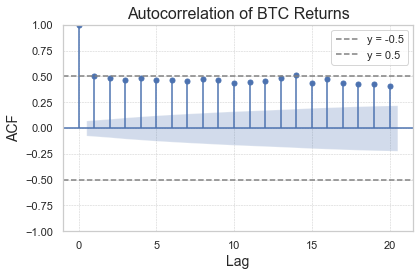

In [16]:
sns.set(style="whitegrid")
def plot_custom_acf(data, title, y1=-0.5, y2=0.5):
    plt.figure(figsize=(12, 6))
    plot_acf(data, lags=20)
    plt.axhline(y=y1, color='gray', linestyle='--', linewidth=1.5, label=f'y = {y1}')
    plt.axhline(y=y2, color='gray', linestyle='--', linewidth=1.5, label=f'y = {y2}')
    plt.title(title, fontsize=16)
    plt.xlabel('Lag', fontsize=14)
    plt.ylabel('ACF', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

plot_custom_acf(spy_day_return['return'].dropna(), 'Autocorrelation of BTC Returns')

#### Number of jumps detected per day

In [24]:
spy_min_return.index = pd.to_datetime(spy_min_return.index)

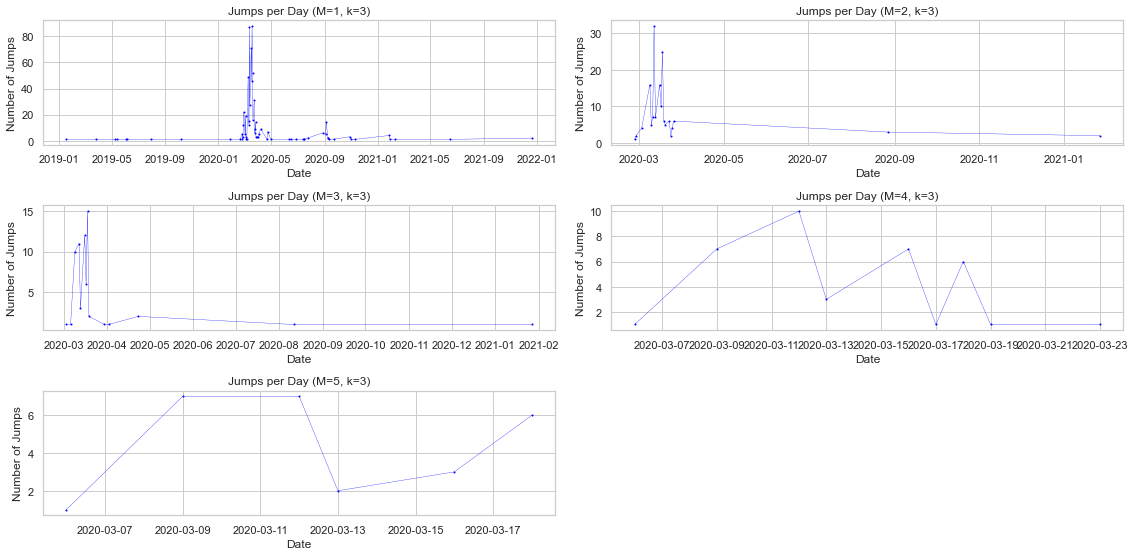

In [32]:
plt.figure(figsize=(16, 10))

for i, (M, k) in enumerate(selected_params):
    # Extract jump detection flags for the current parameters
    jump_detected_col = f'jump_detected_{M}_{k}'
    
    # Ensure the index is a DatetimeIndex
    spy_min_return.index = pd.to_datetime(spy_min_return.index)
    
    # Get the dates where jumps were detected
    jump_dates = spy_min_return[spy_min_return[jump_detected_col] == 1].index
    jump_dates = jump_dates.date  # Convert to date
    jumps_per_day = pd.Series(jump_dates).value_counts().sort_index()
    
    # Plotting
    plt.subplot(4, 2, i + 1)
    plt.plot(jumps_per_day.index, jumps_per_day.values, marker='o', linestyle='-', color='blue', markersize=1, linewidth=0.3)
    plt.title(f'Jumps per Day (M={M}, k={k})')
    plt.xlabel('Date')
    plt.ylabel('Number of Jumps')
    plt.grid(True)
    
plt.tight_layout()
plt.show() 

#### Number of jumps aggregated per hour/day/ week/ month/ year

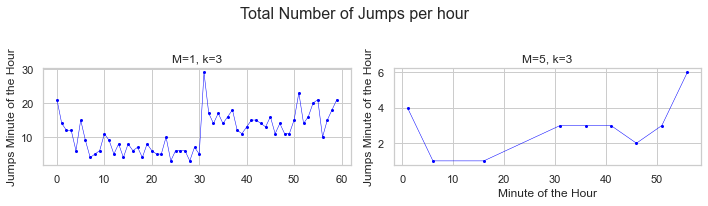

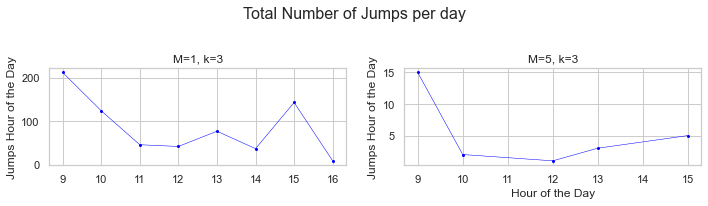

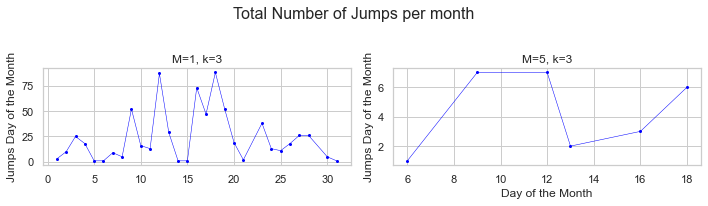

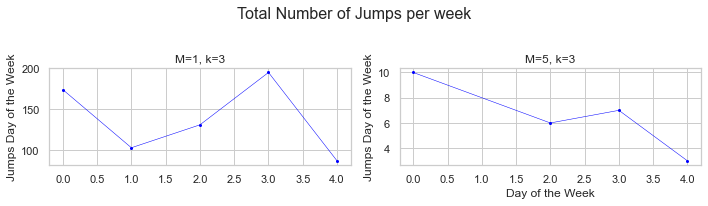

In [37]:
# Function to aggregate jumps per specific period
def aggregate_jumps(jump_dates, period):
    jump_dates_series = pd.Series(jump_dates)
    if period == 'minute':
        return jump_dates_series.dt.minute.value_counts().sort_index()
    elif period == 'hour':
        return jump_dates_series.dt.hour.value_counts().sort_index()
    elif period == 'day':
        return jump_dates_series.dt.day.value_counts().sort_index()
    elif period == 'month':
        return jump_dates_series.dt.month.value_counts().sort_index()
    elif period == 'week':
        return jump_dates_series.dt.dayofweek.value_counts().sort_index()

# Define the periods and labels for aggregation
periods = ['minute', 'hour', 'day', 'week']
period_labels = ['Minute of the Hour', 'Hour of the Day', 'Day of the Month', 'Day of the Week']
aggregation_labels = ['per hour', 'per day', 'per month', 'per week']

# Plotting function
def plot_aggregated_jumps(spy_min_return, selected_params, periods, period_labels, aggregation_labels):
    for period, label, agg_label in zip(periods, period_labels, aggregation_labels):
        fig, axs = plt.subplots(1, 2, figsize=(10, 3))
        fig.suptitle(f'Total Number of Jumps {agg_label}', fontsize=16)
        
        for idx, (M, k) in enumerate(selected_params):
            jump_detected_col = f'jump_detected_{M}_{k}'
            jump_dates = spy_min_return[spy_min_return[jump_detected_col] == 1].index
            
            # Aggregate jumps per specified period
            jumps_aggregated = aggregate_jumps(jump_dates, period)
            
            # For 'per week' aggregation, adjust x-axis to day of the week
            if period == 'week':
                days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
                if len(jumps_aggregated) == len(days_of_week):
                    jumps_aggregated.index = days_of_week
                else:
                    # Optionally, you can print a warning or handle this case differently
                    print(f"Warning: The number of aggregated jumps ({len(jumps_aggregated)}) does not match the days of the week.")

            # Plot the aggregated jumps on the respective subplot
            axs[idx].plot(jumps_aggregated.index, jumps_aggregated.values, marker='o', linestyle='-', color='blue', markersize=2, linewidth=0.5)
            axs[idx].set_title(f'M={M}, k={k}')
            axs[idx].set_ylabel(f'Jumps {label}')
            axs[idx].grid(True)
        
        axs[idx].set_xlabel(label)  # Set x-axis label for the last subplot
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Run the plotting function with selected_params
selected_params = [(1, 3), (5, 3)]
plot_aggregated_jumps(spy_min_return, selected_params, periods, period_labels, aggregation_labels)


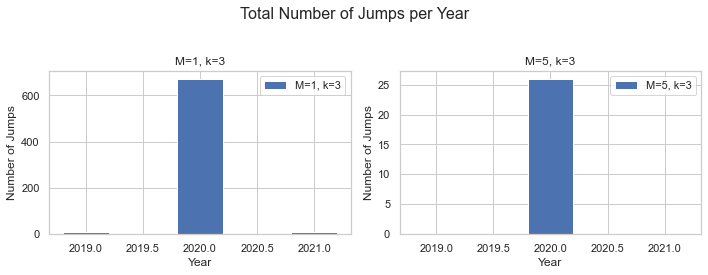

In [38]:
selected_params = [(1, 3),(5, 3)]
# Function to aggregate jumps per year
def aggregate_jumps_by_year(jump_dates):
    jump_dates_series = pd.Series(jump_dates)
    return jump_dates_series.dt.year.value_counts().sort_index()

# Plotting function for aggregated jumps per year
def plot_aggregated_jumps_by_year(spy_min_return, selected_params):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=False)
    fig.suptitle('Total Number of Jumps per Year', fontsize=16)
    
    for idx, (M, k) in enumerate(selected_params):
        jump_detected_col = f'jump_detected_{M}_{k}'
        jump_dates = spy_min_return[spy_min_return[jump_detected_col] == 1].index
        
        # Aggregate jumps per year
        jumps_aggregated = aggregate_jumps_by_year(jump_dates)
        
        # Plot the aggregated jumps on the bar plot
        ax = axs[idx]
        ax.bar(jumps_aggregated.index, jumps_aggregated.values, width=0.4, label=f'M={M}, k={k}')
        ax.set_xlabel('Year')
        ax.set_ylabel('Number of Jumps')
        ax.set_title(f'M={M}, k={k}')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run the plotting function
plot_aggregated_jumps_by_year(spy_min_return, selected_params)

#### Plot of aggregated trading volumes

In [ ]:
# Function to aggregate volume per specific period
def aggregate_volume(volume_data, period):
    if period == 'minute':
        return volume_data.groupby(volume_data.index.minute).sum()
    elif period == 'hour':
        return volume_data.groupby(volume_data.index.hour).sum()
    elif period == 'day':
        return volume_data.groupby(volume_data.index.day).sum()
    elif period == 'week':
        return volume_data.groupby(volume_data.index.weekday).sum()
    elif period == 'month':
        return volume_data.groupby(volume_data.index.month).sum()

# Define the periods and labels for aggregation
periods = ['hour', 'day', 'week', 'month']
period_labels = ['Hour of the Day', 'Day of the Month', 'Day of the Week', 'Month of the Year']
aggregation_labels = ['per hour', 'per day', 'per week', 'per month']

# Plotting function
def plot_aggregated_volume(btc_min_return, periods, period_labels, aggregation_labels):
    for period, label, agg_label in zip(periods, period_labels, aggregation_labels):
        fig, ax = plt.subplots(figsize=(6, 3))
        fig.suptitle(f'Total Trading Volume {agg_label}', fontsize=16)
        
        # Aggregate volume per specified period
        volume_aggregated = aggregate_volume(btc_min_return['volume'], period)
        
        # Plot the aggregated volume
        ax.plot(volume_aggregated.index, volume_aggregated.values, marker='o', linestyle='-', color='blue', markersize=2, linewidth=0.5)
        ax.set_title(f'{label}')
        ax.set_ylabel(f'Volume')
        ax.grid(True)
        
        # Set x-axis label
        ax.set_xlabel(label)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# Run the plotting function with periods and labels
plot_aggregated_volume(btc_min_return, periods, period_labels, aggregation_labels)

#### Histogram of jump sizes

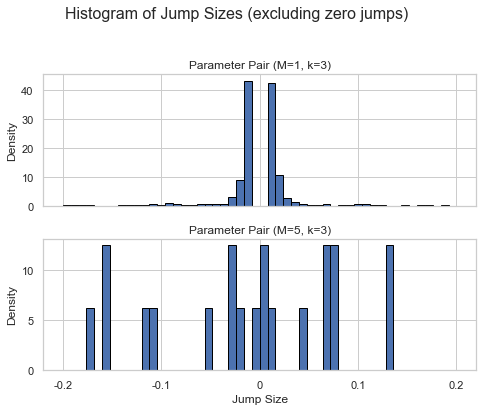

In [39]:
# Function to plot histograms of jump sizes for specific parameter pairs
def plot_jump_size_histograms(spy_min_return, selected_params):
    fig, axs = plt.subplots(len(selected_params), 1, figsize=(7, 6), sharex=True)
    fig.suptitle('Histogram of Jump Sizes (excluding zero jumps)', fontsize=16)
    
    for idx, (M, k) in enumerate(selected_params):
        jump_size_col = f'jump_size_{M}_{k}'
        jump_sizes = spy_min_return[jump_size_col][spy_min_return[jump_size_col] != 0].dropna()
        
        # Plot histogram with adjusted parameters
        axs[idx].hist(jump_sizes, bins=50, edgecolor='black', density=True, range=(-0.2, 0.2))
        axs[idx].set_title(f'Parameter Pair (M={M}, k={k})')
        axs[idx].set_ylabel('Density')
        axs[idx].grid(True)
        
        # Apply logarithmic scale for better visualization
        axs[idx].set_xscale('symlog')
        
        # Set x-axis ticks and labels
        axs[idx].set_xticks(np.arange(-0.2, 0.3, 0.1))
        axs[idx].set_xticklabels(['-0.2', '-0.1', '0', '0.1', '0.2'])
        
    axs[idx].set_xlabel('Jump Size')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Selected parameter pairs (1, 3) and (5, 3)
selected_params = [(1, 3), (5, 3)]

# Plot histograms for selected parameter pairs
plot_jump_size_histograms(spy_min_return, selected_params)

In [40]:
# Function to calculate statistical summary of jump sizes
def jump_size_summary(spy_min_return, selected_params):
    summaries = []
    for M, k in selected_params:
        jump_size_col = f'jump_size_{M}_{k}'
        jump_sizes = spy_min_return[jump_size_col][spy_min_return[jump_size_col] != 0].dropna()
        
        summary = {
            'Parameter Pair': f'(M={M}, k={k})',
            'Mean': jump_sizes.mean(),
            'Std Dev': jump_sizes.std(),
            'Median': jump_sizes.median(),
            'Min': jump_sizes.min(),
            'Max': jump_sizes.max(),
            '25th Percentile (Q1)': jump_sizes.quantile(0.25),
            '75th Percentile (Q3)': jump_sizes.quantile(0.75),
            'Interquartile Range (IQR)': jump_sizes.quantile(0.75) - jump_sizes.quantile(0.25),
            'Number of Jumps': jump_sizes.size
        }
        summaries.append(summary)
    
    return pd.DataFrame(summaries)

# Get statistical summary
summary = jump_size_summary(spy_min_return, selected_params)
summary

,Parameter Pair,Mean,Std Dev,Median,Min,Max,25th Percentile (Q1),75th Percentile (Q3),Interquartile Range (IQR),Number of Jumps
0,"(M=1, k=3)",0.000063,0.144041,-0.000011,-1.744424,2.085825,-0.012965,0.013348,0.026314,690
1,"(M=5, k=3)",-0.004154,0.577093,0.001691,-1.448173,2.048771,-0.110463,0.075966,0.186429,26
